In [127]:
import re
import random
import pandas as pd
import hashlib

In [128]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [129]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Taxes,100.808199,50.404099,2
Vocab,349.152018,31.741093,11
Azure Functions + Visual Studio,375.301484,26.807249,14
Audit Report Tracker (Sharepoint List),417.495344,26.093459,16
PnP Powershell,454.299922,11.955261,38
OData,532.440950,38.031496,14
Azure AI Search,615.104443,43.936032,14
Debugging in VS Code,636.227322,27.662057,23
Powershell Modules,1038.124850,34.604162,30
Email Auth and Security,1048.162277,80.627867,13


# Histogram

43883.63


<Axes: >

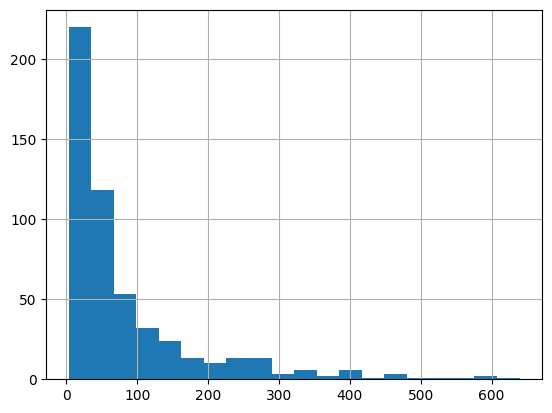

In [130]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [131]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [132]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [133]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 523


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
177,Taxes,"U.S. persons, including citizens, residents, c...",d49a0f63d33fd28e4c5717e6d708a705,-72.186395,50.404099,-72.186395,100.808199,0.805845,2,72.186395
342,Taxes,Taxation: Pass-Through Entities (PTEs) themsel...,1363e717d4866d881bc4e4e790a0d013,-28.621804,50.404099,-72.186395,100.808199,0.805845,2,72.186395
0,Azure AI Foundry,"When using Azure AI Foundry portal, you can di...",6a609b8085870b5f2159093a52131196,-639.543226,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
57,Azure AI Foundry,Managed compute resources and managed virtual ...,e934d445d91e51cd66eca6274432dbba,-202.877450,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
112,Azure AI Foundry,While most of the resources used by Azure AI F...,38bd277c25b531dcc2916d5f39ffd661,-117.652825,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
144,Azure AI Foundry,To reduce the complexity of Azure RBAC managem...,7e3c0720d2b14dcc5011eef66646b573,-92.275652,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
417,Azure AI Foundry,AI Foundry hub: The hub is the top-level resou...,5457ce1477d9d839811ed86682edcc15,-17.513630,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
447,Azure AI Foundry,Azure AI Studio is now Azure AI Foundry portal...,e33cf065446edf8b70eb7af1d027fc36,-12.798246,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
476,Azure AI Foundry,Azure OpenAI: Provides access to the latest Op...,a6c2dbaa79102e6b1481a5297293ac5c,-9.284703,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
1,Search Engine Optimization,Link building is the practice of acquiring bac...,0016cbf46227a4d7dfbe421b0ff4d8b8,-607.395774,182.713640,-607.395774,2009.850043,0.241361,11,607.395774


# Focus on one header

In [134]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [135]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [136]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [137]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [138]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [139]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Max

In [140]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [141]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [142]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [143]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
177,Taxes,"U.S. persons, including citizens, residents, c...",d49a0f63d33fd28e4c5717e6d708a705,-72.186395,50.404099,-72.186395,100.808199,0.805845,2,72.186395
342,Taxes,Taxation: Pass-Through Entities (PTEs) themsel...,1363e717d4866d881bc4e4e790a0d013,-28.621804,50.404099,-72.186395,100.808199,0.805845,2,72.186395
0,Azure AI Foundry,"When using Azure AI Foundry portal, you can di...",6a609b8085870b5f2159093a52131196,-639.543226,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
57,Azure AI Foundry,Managed compute resources and managed virtual ...,e934d445d91e51cd66eca6274432dbba,-202.877450,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
112,Azure AI Foundry,While most of the resources used by Azure AI F...,38bd277c25b531dcc2916d5f39ffd661,-117.652825,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
144,Azure AI Foundry,To reduce the complexity of Azure RBAC managem...,7e3c0720d2b14dcc5011eef66646b573,-92.275652,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
417,Azure AI Foundry,AI Foundry hub: The hub is the top-level resou...,5457ce1477d9d839811ed86682edcc15,-17.513630,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
447,Azure AI Foundry,Azure AI Studio is now Azure AI Foundry portal...,e33cf065446edf8b70eb7af1d027fc36,-12.798246,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
476,Azure AI Foundry,Azure OpenAI: Provides access to the latest Op...,a6c2dbaa79102e6b1481a5297293ac5c,-9.284703,155.992247,-639.543226,1091.945732,0.953248,7,639.543226
1,Search Engine Optimization,Link building is the practice of acquiring bac...,0016cbf46227a4d7dfbe421b0ff4d8b8,-607.395774,182.713640,-607.395774,2009.850043,0.241361,11,607.395774


In [144]:
existing_cards.head(10)['age'].sum()

-1800.1497054934152